In [1]:
import torch
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bayes
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier
import xgboost as xgb # Gradient Boosting Machines
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.tree import DecisionTreeClassifier # Decision Trees

from sklearn.model_selection import GridSearchCV

# For the fully connected layers
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

### Getting training and testing data

This code was taken from context_encoder

In [2]:
X_train = torch.load('data/train_test_data/x_train_contextencoder.pt')
y_train = pd.read_csv('data/train_test_data/y_train_contextencoder.csv')

X_test = torch.load('data/train_test_data/x_test_contextencoder.pt')
y_test = pd.read_csv('data/train_test_data/y_test_contextencoder.csv')


In [3]:
X_train = X_train.detach().numpy()
X_train

array([[-0.02106448,  0.03402166,  0.41411582, ..., -0.02596821,
         0.02658154, -0.04077357],
       [ 0.03329327,  0.03269034,  0.16543297, ..., -0.02377809,
         0.02932434, -0.03381041],
       [ 0.0602355 ,  0.04271767,  0.09228501, ..., -0.02530025,
         0.02808624, -0.03916406],
       ...,
       [ 0.07361973,  0.05439407,  0.03723658, ...,  0.03439288,
        -0.07036522, -0.06370108],
       [ 0.07075164,  0.05669767,  0.03161025, ...,  0.04010216,
        -0.193852  , -0.11699423],
       [ 0.07090013,  0.06418796,  0.0271789 , ...,  0.08496671,
        -0.24383666, -0.20624714]], dtype=float32)

In [4]:
y_train = y_train['Emotion']
y_train.head()

0    0
1    0
2    0
3    0
4    1
Name: Emotion, dtype: int64

In [5]:
X_test = X_test.detach().numpy()

In [6]:
y_test = y_test['Emotion']
y_test.head()

0    1
1    6
2    0
3    0
4    0
Name: Emotion, dtype: int64

In [7]:
print(f"Length of X_train: {X_train.shape}")
print(f"Length of y_train: {y_train.shape}")
print(f"Length of X_test: {X_test.shape}")
print(f"Length of y_test: {y_test.shape}")

Length of X_train: (12840, 300)
Length of y_train: (12840,)
Length of X_test: (3400, 300)
Length of y_test: (3400,)


In [8]:
file1 = open('data/dump/label_encoder.pkl', 'rb')
file2 = open('data/dump/label_decoder.pkl', 'rb')
label_encoder = pickle.load(file1)
label_decoder = pickle.load(file2)
file1.close()
file2.close()

# Print the label_encoder dictionary to see the mapping
print("Label Encoder Mapping (Emotion -> Encoded Label):")
for label, encoded_label in label_encoder.items():
    print(f"{label}: {encoded_label}")

Label Encoder Mapping (Emotion -> Encoded Label):
neutral: 0
surprise: 1
fear: 2
sadness: 3
joy: 4
disgust: 5
anger: 6


### Gaussian Naive Bayes

In [9]:
# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Define the parameter grid for 'var_smoothing'
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

# Initialize the GridSearchCV object with GaussianNB classifier and the parameter grid
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Best Parameters:  {'var_smoothing': 1.0}
Best Score:  0.23021806853582555
Accuracy on Test Set:  0.15176470588235294
Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1615
           1       0.00      0.00      0.00       352
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00       263
           4       0.00      0.00      0.00       495
           5       0.00      0.00      0.00        99
           6       0.15      1.00      0.26       516

    accuracy                           0.15      3400
   macro avg       0.02      0.14      0.04      3400
weighted avg       0.02      0.15      0.04      3400



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Support Vector Machines

In [10]:
# Parameter grid for the GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],  # Type of SVM kernel
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'degree': [2, 3, 4]  # Degree of the polynomial kernel function ('poly'). Ignored by all other kernels.
}

# Initialize the SVM classifier
svm = SVC(random_state=42)

# Initialize the GridSearchCV object with SVM classifier and the parameter grid
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=  14.4s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=  14.5s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=  13.9s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=  13.8s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=  14.5s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  11.6s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  11.2s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  11.3s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  11.3s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  11.6s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=  11.2s
[CV] END ..........C=0.1, degree=2, gamma=scale

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest Classifier

In [11]:
# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV object with Random Forest classifier and the parameter grid
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  33.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  32.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  32.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  32.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  33.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tot

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Gradient Boosting Machines

In [12]:
# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 6, 10],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.3],  # Step size shrinkage used to prevent overfitting
    'n_estimators': [100, 200, 300],  # Number of trees you want to build
    'objective': ['multi:softmax'],  # Multiclass classification using the softmax objective
    'eval_metric': ['mlogloss'],  # Evaluation metrics for validation data
    'num_class': [len(set(y_train))]  # Number of classes in the objective function
}

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=100, num_class=7, objective=multi:softmax; total time=   2.4s
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=100, num_class=7, objective=multi:softmax; total time=   2.4s
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=100, num_class=7, objective=multi:softmax; total time=   2.4s
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=200, num_class=7, objective=multi:softmax; total time=   4.5s
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=200, num_class=7, objective=multi:softmax; total time=   4.4s
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=200, num_class=7, objective=multi:softmax; total time=   4.3s
[CV] END eval_metric=mlogloss, learning_rate=0.01, max_depth=3, n_estimators=300, num_class=7, objective=

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### K-Nearest Neighbors

In [33]:
# Define the parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Metric used for the distance computation
}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV object with KNN classifier and the parameter grid
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters:  {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Best Score:  0.4478193146417445
Accuracy on Test Set:  0.2011764705882353
Classification Report: 
              precision    recall  f1-score   support

           0       0.48      0.16      0.24      1615
           1       0.00      0.00      0.00       352
           2       0.00      0.00      0.00        60
           3       0.07      0.00      0.01       263
           4       0.15      0.86      0.26       495
           5       0.00      0.00      0.00        99
           6       0.00      0.00      0.00       516

    accuracy                           0.20      3400
   macro avg       0.10      0.15      0.07      3400
weighted avg       0.25      0.20      0.15      3400



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistic Regression

In [14]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l2', None],  # Norm used in the penalization
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['lbfgs', 'saga', 'newton-cg']  # Algorithm to use in the optimization problem
}

# Note: 'saga' solver supports both l1 and l2 penalty, while 'lbfgs' and 'newton-cg' support only l2.
# Make sure the combinations of solver and penalty are compatible.

# Initialize the Logistic Regression classifier
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial')

# Initialize GridSearchCV object with Logistic Regression classifier and the parameter grid
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   1.6s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   1.8s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   1.7s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   1.7s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   1.8s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   1.0s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.8s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   1.1s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.9s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.7s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=None, solver=lbfgs; total time=   4.4s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=None, solver=lbfgs; total time=   4.7s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=0.01, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.01, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .............C=0.01, penalty=None, solver=newton-cg; total time=  41.7s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .............C=0.01, penalty=None, solver=newton-cg; total time= 1.1min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .............C=0.01, penalty=None, solver=newton-cg; total time=  43.9s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .............C=0.01, penalty=None, solver=newton-cg; total time=  35.5s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END .............C=0.01, penalty=None, solver=newton-cg; total time= 1.0min
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.4s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.5s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.3s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.3s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   1.3s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   2.3s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.7s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.9s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.2s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   0.9s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=None, solver=lbfgs; total time=   4.4s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=0.1, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=0.1, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=0.1, penalty=None, solver=newton-cg; total time=  41.4s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=0.1, penalty=None, solver=newton-cg; total time= 1.1min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=0.1, penalty=None, solver=newton-cg; total time=  43.7s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=0.1, penalty=None, solver=newton-cg; total time=  35.4s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..............C=0.1, penalty=None, solver=newton-cg; total time= 1.0min
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   1.1s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   1.2s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   3.4s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   3.4s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   3.4s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   3.4s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   3.3s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   2.4s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   1.7s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   3.3s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   2.4s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   1.9s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1, penalty=None, solver=lbfgs; total time=   4.6s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=1, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=1, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=1, penalty=None, solver=newton-cg; total time=  41.8s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=1, penalty=None, solver=newton-cg; total time= 1.1min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=1, penalty=None, solver=newton-cg; total time=  44.2s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=1, penalty=None, solver=newton-cg; total time=  35.5s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=1, penalty=None, solver=newton-cg; total time= 1.0min
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   3.2s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   3.1s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   3.3s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   3.1s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   3.5s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=  22.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=  18.8s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=  18.5s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=  19.8s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=  22.2s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   6.2s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   4.0s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   4.3s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   4.4s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   4.1s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=None, solver=lbfgs; total time=   4.6s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=10, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................C=10, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...............C=10, penalty=None, solver=newton-cg; total time=  41.7s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...............C=10, penalty=None, solver=newton-cg; total time= 1.1min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...............C=10, penalty=None, solver=newton-cg; total time=  43.7s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...............C=10, penalty=None, solver=newton-cg; total time=  35.6s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ...............C=10, penalty=None, solver=newton-cg; total time= 1.0min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   4.4s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l2, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l2, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l2, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l2, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l2, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   7.5s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   7.3s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   8.3s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   8.4s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=  12.0s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=None, solver=lbfgs; total time=   4.4s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=None, solver=lbfgs; total time=   4.6s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..................C=100, penalty=None, solver=lbfgs; total time=   4.5s


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...................C=100, penalty=None, solver=saga; total time= 1.3min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=100, penalty=None, solver=newton-cg; total time=  41.4s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=100, penalty=None, solver=newton-cg; total time= 1.1min


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=100, penalty=None, solver=newton-cg; total time=  43.9s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ..............C=100, penalty=None, solver=newton-cg; total time=  35.7s


c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV] END ..............C=100, penalty=None, solver=newton-cg; total time= 1.0min
Best Parameters:  {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Score:  0.47904984423676017
Accuracy on Test Set:  0.10352941176470588
Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1615
           1       0.10      1.00      0.19       352
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00       263
           4       0.00      0.00      0.00       495
           5       0.00      0.00      0.00        99
           6       0.00      0.00      0.00       516

    accuracy                           0.10      3400
   macro avg       0.01      0.14      0.03      3400
weighted avg       0.01      0.10      0.02      3400



c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData

### Decision Trees

In [15]:
# Initialize the Decision Tree classifier
decision_tree = DecisionTreeClassifier(max_depth=None, criterion='gini', random_state=42)

# Fitting the Decision Tree to the Training set
decision_tree.fit(X_train, y_train)

# Predicting the Test set results# Define the parameter grid for Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

# Initialize the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV object with Decision Tree classifier and the parameter grid
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Predict on the test set with the best parameters
y_pred = grid_search.predict(X_test)

# Evaluate the classifier with the best parameters
print("Accuracy on Test Set: ", accuracy_score(y_test, y_pred))
print("Classification Report: ")
print(classification_report(y_test, y_pred))
y_pred = decision_tree.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   7.6s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   9.3s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   8.9s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   8.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   8.8s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   7.5s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   9.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   8.8s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   7.9s
[CV] END criterion=gini, max_

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Fully Connected Layers - Jon Implementation

In [16]:
class EmotionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(EmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output without activation; softmax will be applied externally if needed
        return x

In [17]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Wraps tensors into a dataset. Used to combine the input features and labels into a single dataset object for both training and testing data.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Provides an iterable over the given dataset, supporting automatic batching, sampling, shuffling, and multiprocess data loading.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) 

In [18]:
model = EmotionClassifier(input_size=X_train.shape[1], hidden_size=256, num_classes=len(set(y_train)))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
num_epochs = 250
accuracy_list = []
loss_list = []

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    # After updating weights in each epoch, add code to evaluate on the test set or a validation set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Initialize variables to track accuracy, for example
        correct, total = 0, 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total

    accuracy_list.append(accuracy)
    loss_list.append(loss.item())
    
    model.train()  # Set the model back to training mode
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy}%')


Epoch [0/250], Loss: 1.6391, Accuracy: 47.5%
Epoch [10/250], Loss: 1.7074, Accuracy: 47.5%
Epoch [20/250], Loss: 1.2881, Accuracy: 44.5%
Epoch [30/250], Loss: 1.7067, Accuracy: 44.26470588235294%
Epoch [40/250], Loss: 1.4469, Accuracy: 44.55882352941177%
Epoch [50/250], Loss: 1.6461, Accuracy: 44.470588235294116%
Epoch [60/250], Loss: 1.2734, Accuracy: 44.35294117647059%
Epoch [70/250], Loss: 1.7703, Accuracy: 44.3235294117647%
Epoch [80/250], Loss: 1.4375, Accuracy: 44.05882352941177%
Epoch [90/250], Loss: 1.3367, Accuracy: 44.205882352941174%
Epoch [100/250], Loss: 1.5072, Accuracy: 44.35294117647059%
Epoch [110/250], Loss: 1.5495, Accuracy: 44.3235294117647%
Epoch [120/250], Loss: 1.2539, Accuracy: 44.44117647058823%
Epoch [130/250], Loss: 1.3615, Accuracy: 43.38235294117647%
Epoch [140/250], Loss: 1.4137, Accuracy: 43.529411764705884%
Epoch [150/250], Loss: 1.3289, Accuracy: 42.588235294117645%
Epoch [160/250], Loss: 1.3698, Accuracy: 44.411764705882355%
Epoch [170/250], Loss: 1.18

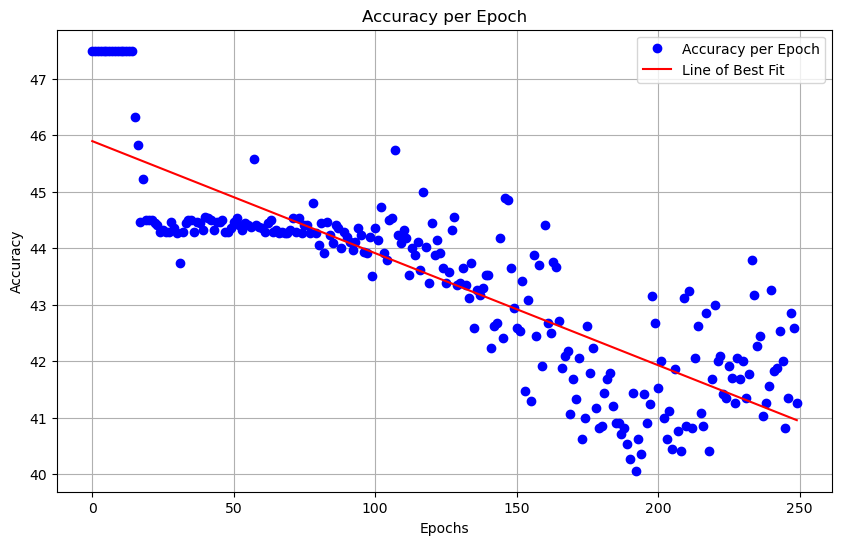

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'accuracy_list' contains the accuracy values for each epoch
x = np.arange(len(accuracy_list))  # Using np.arange instead of range for array operations
y = np.array(accuracy_list)

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='', color='b', label='Accuracy per Epoch')

# Compute the coefficients for the line of best fit
coefficients = np.polyfit(x, y, 1)
# Generate the values for the line of best fit
polynomial = np.poly1d(coefficients)
y_fit = polynomial(x)

# Plot the line of best fit
plt.plot(x, y_fit, 'r-', label='Line of Best Fit')

plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


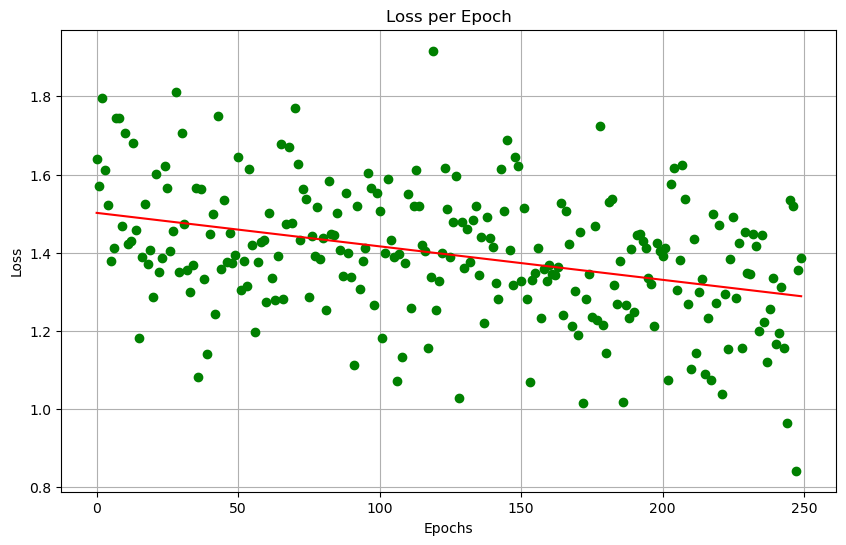

In [32]:
x = range(len(loss_list))
plt.figure(figsize=(10, 6))
plt.plot(x, loss_list, marker='o', linestyle='', color='g')

# Compute the coefficients for the line of best fit
coefficients = np.polyfit(x, loss_list, 1)
# Generate the values for the line of best fit
polynomial = np.poly1d(coefficients)
y_fit = polynomial(x)

# Plot the line of best fit
plt.plot(x, y_fit, 'r-', label='Line of Best Fit')

plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Fully Connected Layers - Elijah Implementation

FC layers referenced from https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65

In [22]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [23]:
import numpy as np

# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [24]:
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [25]:
# activation function and its derivative
def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1-np.tanh(x)**2

In [26]:
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

In [27]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

In [28]:
# network
net = Network()
net.add(FCLayer(300, 0))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(1,0))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
net.fit(X_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net.predict(X_test)
print(out)

ValueError: shapes (1,0) and (1,0) not aligned: 0 (dim 1) != 1 (dim 0)